# Exercise 12.3 - Solution
## Discriminative localization  (CAM)
In this exercise we will create class activation maps (CAMs) for predictions made by a model trained to classify magentic phases (see [Exercise 7_1](Exercise_7_1_solution.ipynb)).
 1. Pick out two correctly and two wrongly classified images classified with a convolutional network.
 2. Look at Exercise 8.1 to extract weights and feature maps from the trained network model.
 3. Create and plot the class activation maps and compare them with the images in order to see which regions lead to the prediction.


In [1]:
from tensorflow import keras
import numpy as np
callbacks = keras.callbacks
layers = keras.layers

print("keras", keras.__version__)

keras 2.4.0


/home/jonas/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/jonas/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/jonas/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/jonas/.local/lib/python3.6/site-packages/tensorboard/compat/tensorf

### Load and prepare dataset
See https://doi.org/10.1038/nphys4035 for more information

In [2]:
import gdown
url = "https://drive.google.com/u/0/uc?export=download&confirm=HgGH&id=1Ihxt1hb3Kyv0IrjHlsYb9x9QY7l7n2Sl"
output = 'ising_data.npz'
gdown.download(url, output, quiet=True)

f = np.load(output)
n_train = 20000

x_train, x_test = f["C"][:n_train], f["C"][n_train:]
T_train, T_test = f["T"][:n_train], f["T"][n_train:]

Tc = 2.27
y_train = np.zeros_like(T_train)
y_train[T_train > Tc] = 1
y_train = keras.utils.to_categorical(y_train, 2)

y_test = np.zeros_like(T_test)
y_test[T_test > Tc] = 1
y_test = keras.utils.to_categorical(y_test, 2)

### Plot data

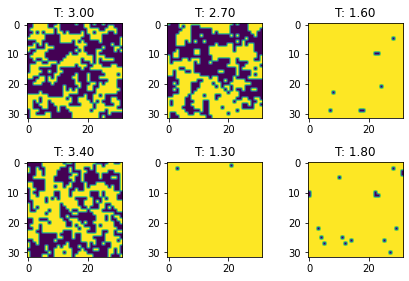

In [3]:
import matplotlib.pyplot as plt

for i,j in enumerate(np.random.choice(n_train, 6)):
    plt.subplot(2,3,i+1)
    image = x_train[j]
    plot = plt.imshow(image)
    plt.title("T: %.2f" % T_train[j])

plt.tight_layout()
plt.show()

### Definition of the model

Define a CNN for discriminative localization. Note that the CNN must use `GlobalAveragePooling2D` after the convolutional part and must not feature more than a single fully-connected layer as output.

In [4]:
model = keras.models.Sequential()
model.add(layers.InputLayer(input_shape=(32, 32)))
model.add(layers.Reshape((32, 32,1)))
model.add(layers.Convolution2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.Convolution2D(16, (3, 3), padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
global_average_pooling2d (Gl (None, 32)                0

### prepare model for training

In [5]:
model.compile(
    loss='binary_crossentropy',
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy'])


In [6]:
results = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=50,
                    verbose=2,
                    validation_split=0.1,
                    callbacks=[
                        callbacks.EarlyStopping(patience=5, verbose=1),
                        callbacks.ReduceLROnPlateau(factor=0.67, patience=2, verbose=1)]
                    )

Epoch 1/50
282/282 - 12s - loss: 0.1038 - accuracy: 0.9574 - val_loss: 0.0442 - val_accuracy: 0.9835
Epoch 2/50
282/282 - 17s - loss: 0.0491 - accuracy: 0.9802 - val_loss: 0.0412 - val_accuracy: 0.9830
Epoch 3/50
282/282 - 23s - loss: 0.0469 - accuracy: 0.9801 - val_loss: 0.0381 - val_accuracy: 0.9825
Epoch 4/50
282/282 - 23s - loss: 0.0451 - accuracy: 0.9817 - val_loss: 0.0380 - val_accuracy: 0.9850
Epoch 5/50
282/282 - 26s - loss: 0.0458 - accuracy: 0.9803 - val_loss: 0.0401 - val_accuracy: 0.9840

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0006700000318232924.
Epoch 6/50
282/282 - 22s - loss: 0.0418 - accuracy: 0.9822 - val_loss: 0.0479 - val_accuracy: 0.9820
Epoch 7/50
282/282 - 22s - loss: 0.0426 - accuracy: 0.9816 - val_loss: 0.0397 - val_accuracy: 0.9825

Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0004489000252215192.
Epoch 8/50
282/282 - 24s - loss: 0.0421 - accuracy: 0.9826 - val_loss: 0.0358 - val_accuracy: 0.9855
Epoch 9/50
282/282 - 23s - los

### Evaluate training

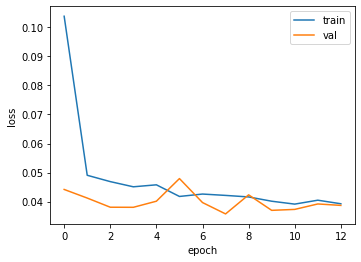

In [7]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

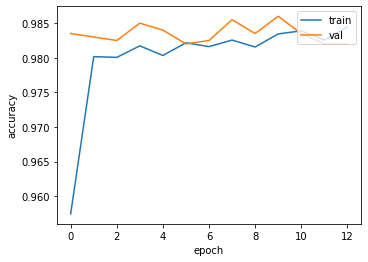

In [8]:
plt.figure(1, (12, 4))
plt.subplot(1, 2, 1)
plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

## Create class activation maps

Extract the activations of the last convolutional layer.

In [9]:
conv = model.layers[-4]
conv_func = keras.models.Model(model.inputs, conv.output)
A = conv_func.predict(x_test)
print(A.shape)

(6000, 16, 16, 32)


Create the class activation maps by omitting the global average pooling operation and applying the weights of the single classification layer to the extracted activations.

In [10]:
W, b = model.layers[-1].get_weights()
M = np.einsum('ixyz,zc->ixyc', A, W) + b

In [11]:
y_pred = model.predict(x_test, verbose=1)

y_pred = np.argmax(y_pred, axis=-1).round()
y_true = np.argmax(y_test, axis=-1).round()

188/188 [==============================] - 3s 15ms/step


In [12]:
idx_correct = np.where(y_true == y_pred)[0]

In [13]:
idx_wrong = np.where(y_true != y_pred)[0]

### Plot the class activation maps for examples just below and above the critical temperature

In [14]:
def plot_CAM(M, x_test, idx):
    X = x_test[idx,...]  # the image itself
    M1 = M[idx,..., 0]  # activation map for T < Tc
    M2 = M[idx,..., 1]  # activation map for T > Tc

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4))
    fig.subplots_adjust(right=0.8, wspace=0.05)

    # plot image (twice)
    ax1.imshow(X, cmap=plt.cm.gray, extent=(0, 32, 0, 32))
    ax2.imshow(X, cmap=plt.cm.gray, extent=(0, 32, 0, 32))

    # plot overlay of class activations, perform upsampling by bilinear interpolation
    kwargs = dict(cmap=plt.cm.magma, extent=(0, 32, 0, 32),
                  interpolation='bilinear', alpha=0.7)
    _1 = ax1.imshow(M1, **kwargs)
    _2 = ax2.imshow(M2, **kwargs)

    cbar = fig.colorbar(_1, cax=fig.add_axes([0.82, 0.1, 0.02, 0.8]))
    cbar.set_label('Class activation')
    ax1.set_title('Ferromagnetic CAM (T < Tc)')
    ax2.set_title('Paramagnetic CAM (T > Tc)')
    plt.show()

Plot correctly classified sample 

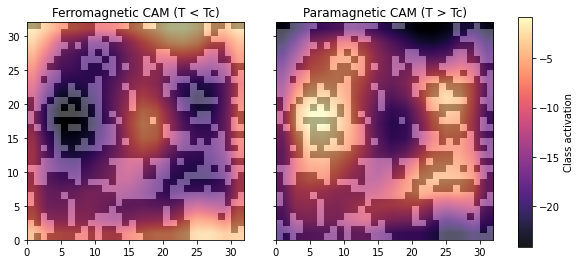

In [15]:
plot_CAM(M, x_test, np.random.choice(idx_correct, 1)[0])

Plot wrongly classified sample 

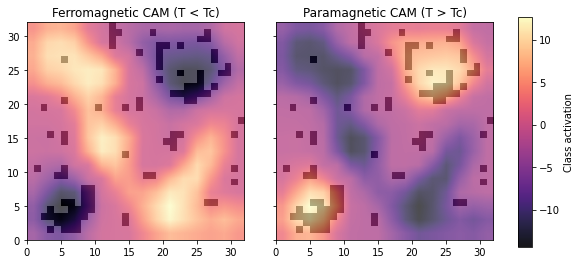

In [16]:
plot_CAM(M, x_test, np.random.choice(idx_wrong, 1)[0])